In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
import gcm_filters
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## In this notebook we perform temporal and spatial filtering to define APE for the mean and eddy parts of the flow, where 'eddy' is defined as the mesoscale baroclinic eddy field. We will first compute APE on each native grid. Then, we will coarsen to 1/4 degree, perform filtering, and interpolate back onto the native grid. Finally, we add a time-averaging filter to the eddy field to remove the effects of the standing meanders. 

## Reading in 1/4 degree data to define filtering and grid information.

In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20; factor = (72/86400) #1/4 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.

fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(fs)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
Nx = np.size(av.xh)
xhp = av.xh
Ny = np.size(av.yh)
yhp = av.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 240, Ny = 560


### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In [5]:
wet_mask = fs.wet
area = fs.area_t
# Grid define for computations 
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});
grid

<xgcm.Grid>
X Axis (periodic):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (periodic):
  * center   yh --> outer
  * outer    yq --> center

For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [6]:
dxw = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

In [7]:
print('our filter scale is set by a function related to the deformation radius')
Ld = xr.DataArray(av.Rd1.mean(dim='time'))
Ld = Ld.fillna(np.nanmax(Ld))
Ld[0:60,:]=Ld[60,:].mean('xh')
Ld[500:560,:]=Ld[500,:].mean('xh')

#Defining filter scale to be 5 times deformation radius, except near the equator where it is set to 500km.
fscale = (Ld.mean('xh'))*5; fscale[200:360]=500000.
fscale = 0.*Ld+fscale

print(np.nanmin(Ld),np.nanmax(Ld))
print(Ld)

our filter scale is set by a function related to the deformation radius
234.31934 445500.75
<xarray.DataArray 'Rd1' (yh: 560, xh: 240)>
array([[20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       [20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       [20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       ...,
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824],
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824],
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88


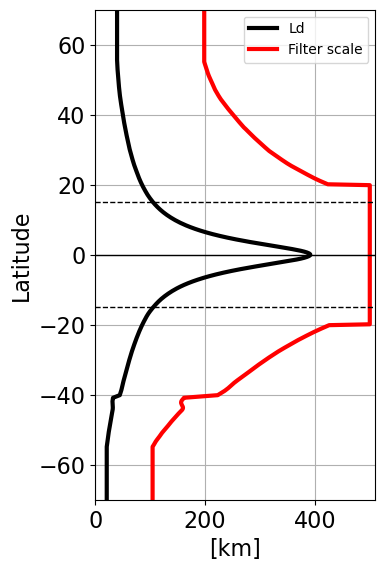

In [8]:
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.7,0.7]) 

ax1.set_xlabel('[km]',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

ax1.plot(Ld.mean('xh')/1000,yhp,'k',linewidth=3)
ax1.plot(fscale.mean('xh')/1000,yhp,'r',linewidth=3)

ax1.plot([0,1000],[0,0],'k',linewidth=1)
ax1.plot([0,1000],[15,15],'--k',linewidth=1)
ax1.plot([0,1000],[-15,-15],'--k',linewidth=1)

ax1.set_xlim([0,510])
ax1.set_ylim([-70,70])
ax1.grid('on')

plt.legend(['Ld','Filter scale'])

In [9]:
#Specifying grid spacings
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

#Setting filter scale
Lf = np.max(fscale.data)
filter_scale = Lf
kappa_w = fscale**2 / Lf**2
kappa_s = fscale**2 / Lf**2
print('done')

done


In [10]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=70, #0 is default
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

n_steps = 70


Filter(filter_scale=500000.0, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

## Now we read in the actual data set to be filtered

In [32]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/

#run=20; cfac=1 #1/4 degree
#run=26; cfac=2 #1/8 degree
run=28; cfac=4 #1/16 degree

fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

#For 1/32 degree:

# %cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# run=33; cfac=8 #1/32 degree NeverWorld setup
# fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
# av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# # print(av)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [33]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
area_t=fs['area_t']

xh = fs.xh
yh = fs.yh

interface_ref=os['H0'].mean('Time'); interface_ref=interface_ref[:-1]

Layer = (os['Layer']);
drho=xr.zeros_like(interface_ref)
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(interface_ref); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.


<xarray.DataArray 'H0' (Interface: 15)>
array([9.23679764e-11, 2.50000000e+01, 7.50000000e+01, 1.75000000e+02,
       3.00000000e+02, 4.50000000e+02, 6.25000000e+02, 8.25000000e+02,
       1.05000000e+03, 1.30000000e+03, 1.60000000e+03, 1.95000000e+03,
       2.35000000e+03, 2.85000000e+03, 3.40000000e+03])
Coordinates:
  * Interface  (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03


In [34]:
h = (av['h'][:,:,:,:]).fillna(0.)
correction = (interface_ref-depth); #if >0 this means h_ref is deeper than topography, we need correction!
correction = correction.where(correction>0.0).fillna(0) #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = xr.zeros_like(h)
for t in range (0,100):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=h[t,i:,:,:].sum(axis=0)-depth
        #interface is negative down, interface_ref_mat is positive down
    print(t)
interface_ref_HIC = interface_ref- correction
interface_ref_HIC=interface_ref_HIC.rename({'Interface': 'zl'}); drho=drho.rename({'Interface': 'zl'})
interface_ref_HIC.coords['zl'] = h['zl']; drho.coords['zl'] = h['zl']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [35]:
eta = (interface+interface_ref_HIC)
eta.shape
# eta2=(interface+interface_ref_HIC)**2.
# APE_net=(0.5*9.81*drho*eta2/(1022.6*depth)).sum('zl')  #to have units of J don't divide by 1022.6*depth, do multiply by area_t
# print(APE_net.shape)

(100, 15, 2240, 960)

## We will now filter eta and compute the APE. Two cases -- for 1/4 degree we just filter on the native grid. For higher resolutions we coarsen, filter, and interpolate back.

### Execute the following cell for 1/4 degree:

In [15]:
%%time
eta_mean_spatial= xr.zeros_like(eta)
for i in range(0,100): #100 5-day averages, so total 500 day span
    print(i)
    eta_mean_spatial[i,:,:,:] = (filter.apply(eta[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field in space
eta_eddy=eta-eta_mean_spatial
eta_eddy=(eta_eddy-eta_eddy.mean('time'))
eta_mean = (eta-eta_eddy)
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done
CPU times: user 7min 27s, sys: 1min 56s, total: 9min 24s
Wall time: 9min 24s


### Execute the following two cells for higher resolutions:

In [36]:
eta_coarse = eta.coarsen(xh=cfac,yh=cfac, boundary="exact").mean() #coarsening
eta_coarse.shape

#Defining the regridder for putting back onto native grid
ds_for_regridder = eta_coarse[0,:,:,:]
#Define regridder
ds_out = xr.Dataset({'lat': (['lat'], av.yh),
                     'lon': (['lon'], av.xh),
                    }
                   )
ds = ds_for_regridder.rename({'xh': 'lon', 'yh': 'lat'})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_560x240_2240x960.nc
Remove file bilinear_560x240_2240x960.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_560x240_2240x960.nc 
Reuse pre-computed weights? False 
Input grid shape:           (560, 240) 
Output grid shape:          (2240, 960) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [37]:
%%time
eta_mean_spatial= xr.zeros_like(eta_coarse)
for i in range(0,100): #100 5-day averages, so total 500 day span
    print(i)
    eta_mean_spatial[i,:,:,:] = (filter.apply(eta_coarse[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field in space
#Back onto native grid:
eta_mean_spatial = regridder(eta_mean_spatial)
eta_mean_spatial = eta_mean_spatial.rename({'lon': 'xh', 'lat': 'yh'})

eta_eddy=eta-eta_mean_spatial
eta_eddy=(eta_eddy-eta_eddy.mean('time'))
eta_mean = (eta-eta_eddy)
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done
CPU times: user 8min 58s, sys: 42.3 s, total: 9min 41s
Wall time: 9min 41s


In [38]:
APE_mean=(0.5*9.81*drho*(eta_mean**2.)/(1022.6*depth)).sum('zl').mean('time')
APE_eddy=(0.5*9.81*drho*(eta_eddy**2.)/(1022.6*depth)).sum('zl').mean('time')

In [39]:
APE_mean.shape

(2240, 960)

In [40]:
yh_00625 = yh;
APE_m00625=APE_mean
APE_e00625=APE_eddy
print('done')

done


Text(0.5, 1.0, 'Zonally averaged mean APE')

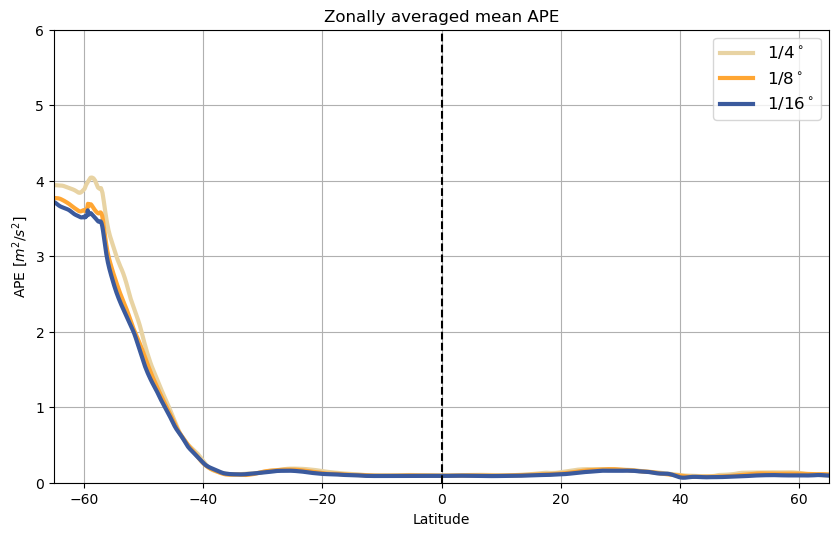

In [44]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
#plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_m025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_m0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_m00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,6);
plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged mean APE')

Text(0.5, 1.0, 'Zonally averaged eddy APE')

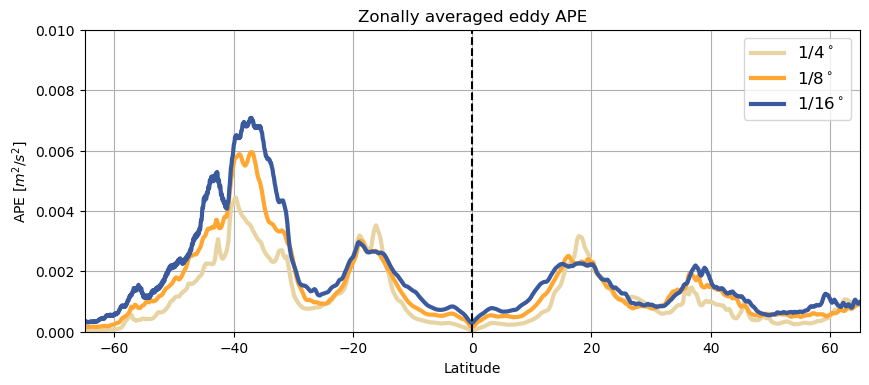

In [43]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_e025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_e0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_e00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_e003125,axis=1),'-',c='#4fb2aa',linewidth=3)

plt.grid()

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,.01);
plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged eddy APE')

In [39]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_025_correct,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_0125_correct,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_00625_correct,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_003125_correct,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,.02);
plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged eddy APE')

NameError: name 'APE_025_correct' is not defined

<Figure size 1000x400 with 0 Axes>

In [23]:
from scipy import interpolate

APE_025   = np.nanmean(APE_025_correct,axis=1)
APE_0125  = np.nanmean(APE_0125_correct,axis=1)
APE_00625 = np.nanmean(APE_00625_correct,axis=1)
#APE_003125= np.nanmean(APE_003125_correct,axis=1)

f1 = interpolate.interp1d(yh_0125, APE_0125)
f2 = interpolate.interp1d(yh_00625, APE_00625)
#f3 = interpolate.interp1d(yh_003125, APE_003125)

APE_0125interp   = f1(yh_025)
APE_00625interp  = f2(yh_025)
#APE_003125interp = f3(yh_025)

frac_025    =APE_025/APE_025
frac_0125   =APE_0125interp/APE_025
frac_00625  =APE_00625interp/APE_025
#frac_003125 =APE_003125interp/APE_025
print('done')

done


Text(0.5, 1.0, 'APE relative to 1/4 degree simulation')

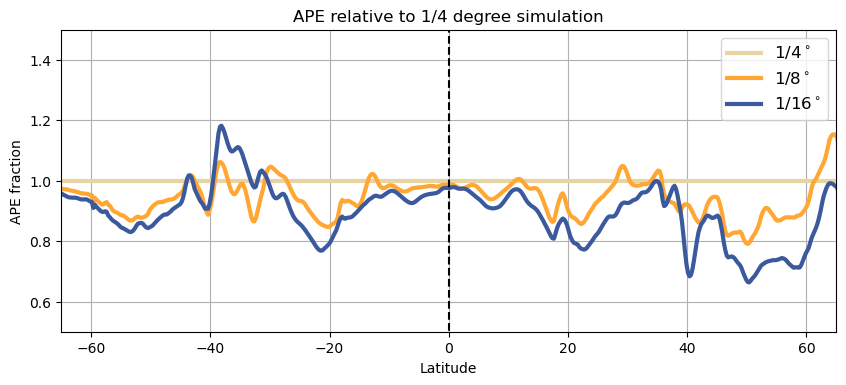

In [27]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,frac_025,'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_025,frac_0125,'-',c='#ffa633',linewidth=3)
plt.plot(yh_025,frac_00625,'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_025,frac_003125,'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0.5,1.5);
plt.xlabel('Latitude')
plt.ylabel('APE fraction')
plt.title('APE relative to 1/4 degree simulation')

In [113]:
2.25e17

2.25e+17